In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import IPython

import re
import os
import warnings

plt.style.use('seaborn')

## Follow the 1st Place

```
    Log-scaled mel-spectrograms
    CNN model with attention, skip connections and auxiliary classifiers
    SpecAugment, Mixup augmentations
    Hand relabeling of the curated dataset samples with a low score
    Ensembling with an MLP second-level model and a geometric mean blending
```


## Data-Set Discription



In [0]:
# Requires to define path

class Hyperparmas:
  path = 'stt_dataset/freesound-audio-tagging-2019' #@param

  test_sample_number = 0 #@param
  test_audio_file = path + '/train_curated/' + os.listdir(path + '/train_curated')[test_sample_number] 


  sampling_rate = 44100 #@param
  hop_length = 345 * 2 #@param
  fmin = 20 #@param
  fmax = sampling_rate // 2 #@param
  n_mels = 128 #@param
  n_fft = n_mels * 20 #@param
  min_seconds = 0.5 #@param
  duration = 2 #@param       # seconds 
  samples = sampling_rate * duration #@param
        # = 44100 * 2 == 88200







hp = Hyperparmas()

In [0]:
train_df = pd.read_csv(hp.path + '/train_curated.csv')

In [4]:
train_df.head()

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping


In [0]:
def label_split(x):
  y = x.split(',')
  return y[0]

In [0]:
train_df['true_label']=train_df.labels.apply(label_split)

In [28]:
train_df.head()

,fname,labels,true_label
0,0006ae4e.wav,Bark,Bark
1,0019ef41.wav,Raindrop,Raindrop
2,001ec0ad.wav,Finger_snapping,Finger_snapping
3,0026c7cb.wav,Run,Run
4,0026f116.wav,Finger_snapping,Finger_snapping


In [0]:
# # DO NOT RUN --- IMPORT df_info.pickle 

# # Additional Check
# # 1) check the audio time
# # 2) check the audio loaded shape

# def audio_time_check(x):
#   path_finder = hp.path + '/train_curated/' + str(x)
#   y, sr = librosa.load(path_finder, sr=44100)
#   result = y.shape[0] / sr
#   return result


# def audio_shape_check(x):
#   path_finder = hp.path + '/train_curated/' + str(x)
#   y, sr = librosa.load(path_finder, sr=44100)
#   result = y.shape[0] / sr
#   return y.shape[0]

# # To figure out the padding requried data, load all audio sources
# train_df['audio_time'] = train_df['fname'].apply(audio_time_check)
# train_df['audio_shape'] = train_df['fname'].apply(audio_shape_check)

In [125]:
train_df.head()

,fname,labels,true_label,audio_time,audio_shape
0,0006ae4e.wav,Bark,Bark,7.039819,310456
1,0019ef41.wav,Raindrop,Raindrop,2.054785,90616
2,001ec0ad.wav,Finger_snapping,Finger_snapping,1.518730,66976
3,0026c7cb.wav,Run,Run,25.530295,1125886
4,0026f116.wav,Finger_snapping,Finger_snapping,1.375011,60638


In [0]:
# pd.to_pickle(train_df, path=hp.path + '/df_info.pickle')

In [137]:
# hp.samples = 88200

train_df[train_df['audio_shape'] < hp.samples].sample(5)

,fname,labels,true_label,audio_time,audio_shape
4891,fc8e862c.wav,Scissors,Scissors,1.793469,79092
1638,54bcb7f7.wav,Tap,Tap,0.394014,17376
2693,8b87a2a8.wav,Male_speech_and_man_speaking,Male_speech_and_man_speaking,0.629751,27772
4798,f76181c4.wav,Male_speech_and_man_speaking,Male_speech_and_man_speaking,1.776327,78336
4434,e5392c3b.wav,"Cutlery_and_silverware,Dishes_and_pots_and_pans",Cutlery_and_silverware,0.496009,21874


### Checking audio preprocessing

In [0]:
y, sr = librosa.load(hp.test_audio_file, sr=44100)

In [26]:
y.shape

(264881,)

In [104]:
y.shape[0] / 44100

5.804988662131519

In [30]:
print(hp.test_audio_file,'\n')

IPython.display.Audio(y, rate=44100)  # Dog - Bark

stt_dataset/freesound-audio-tagging-2019/train_curated/c3119162.wav 



```
def read_audio(conf, pathname, trim_long_data):
    y, sr = librosa.load(pathname, sr=conf.sampling_rate)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if trim_long_data:
            y = y[0:0+conf.samples]
    else: # pad blank
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), conf.padmode)
    return y
```

In [43]:
# load
y, sr = librosa.load(hp.test_audio_file, sr=44100)
print('shape is ', y.shape)

min_samples = int(hp.min_seconds * hp.sampling_rate)
 
print('min samples : ', min_samples)

# trim
y, y_idx = librosa.effects.trim(y)  # return 1) trimmed y , 2) trimmed y's index  
                                    # ex) y == 256000
                                    #     y_idx == [3072, 259072],   the audio length between 3072 ~ 259072 does not have silence
                                    #              +) 259072 - 3072 == 256000

print('trimmed y shape is ', y.shape)

# requires to padding 
#   padding strategy : 1) if the length is shorther than minimum sample
#                      2) if the length is bigger than the size, requires to set the same size

if len(y) > hp.samples:
  y = y[0:0+hp.samples]
else:
  padding = hp.samples - len(y)  # ex) y.shape == 10000, hp.samples = 88200
                                 #     padding = 78200
  offset = padding // 2          # offset = 78200 // 2  == 39100
  y = np.pad(y, (offset, hp.samples - len(y) - offset), 'constant')  # pad (39100, 88200 - 10000 - 39100)
                                                                     # this one line code restrict athe whole length of the array !
  



shape is  (264881,)
min samples :  22050
trimmed y shape is  (256000,)


In [90]:
88200 - 10000 - 39100

39100

#### Appendix I
- np.pad testing

https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html

In [48]:
pad_required_array

array([1, 2, 3, 4, 5, 6, 7])

In [78]:
print('1D-Array')
pad_required_array = np.array([1,2,3,4,5,6,7])
print('Original', pad_required_array)
print('Original_shape', pad_required_array.shape)                                 # Key : (before_1, after_1), ... (before_N, after_N)
print('pan (5,)', np.pad(pad_required_array, pad_width=(5,), mode='constant'))    # pad both
print('pan (5,0)', np.pad(pad_required_array, pad_width=(5,0), mode='constant'))  # pad head
print('pan (5,1)', np.pad(pad_required_array, pad_width=(5,1), mode='constant'))  # pad head: 5, tail: 1


print('\n2D-Array')
pad_required_array = np.array([[1,2,3,4],
                               [11,12,13,14]])
print('Original\n', pad_required_array)
print('Original', pad_required_array.shape)
print('pan (5,)\n', np.pad(pad_required_array, pad_width=(5,), mode='constant'))
print('pan (5,0)\n', np.pad(pad_required_array, pad_width=(5,0), mode='constant'))  # (row, col)  
print('pan (0,5)\n', np.pad(pad_required_array, pad_width=(0,5), mode='constant'))
print('pan (5,7)\n', np.pad(pad_required_array, pad_width=(5,7), mode='constant'))
print('pan [(1,1), (1,1)]\n', np.pad(pad_required_array, pad_width=[(1,1), (1,1)], mode='constant'))
print('pan [(1,1), (1,2)]\n', np.pad(pad_required_array, pad_width=[(1,1), (1,2)], mode='constant'))
print('pan [(5,), (5,)]\n', np.pad(pad_required_array, pad_width=[(5,), (5,)], mode='constant'))

1D-Array
Original [1 2 3 4 5 6 7]
Original_shape (7,)
pan (5,) [0 0 0 0 0 1 2 3 4 5 6 7 0 0 0 0 0]
pan (5,0) [0 0 0 0 0 1 2 3 4 5 6 7]
pan (5,1) [0 0 0 0 0 1 2 3 4 5 6 7 0]

2D-Array
Original
 [[ 1  2  3  4]
 [11 12 13 14]]
Original (2, 4)
pan (5,)
 [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  2  3  4  0  0  0  0  0]
 [ 0  0  0  0  0 11 12 13 14  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
pan (5,0)
 [[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0 1

In [100]:
# Strategy check
# Description : y = 10000, min_length = 20000

padding_min_length = 20000
padding_required_y = np.random.normal(0., 1., size=(10000,))

# the original array should be place on the "Middel of the padding"
padding_required_length = padding_min_length - padding_required_y.shape[0]
print(padding_required_length)

# test_1  padding forword
padding_test_1 = np.pad(padding_required_y, (padding_required_length, 0), 'constant') 
print(padding_test_1)
print(padding_test_1.shape)
print()
# test_2 padding backword
padding_test_2 = np.pad(padding_required_y, (0, padding_required_length), 'constant')
print(padding_test_2)
print(padding_test_2.shape)
print()
# test_3 padding both side
padding_test_3 = np.pad(padding_required_y, (padding_required_length//2, ), 'constant')
print(padding_test_3)
print(padding_test_3.shape)
# test_4_padding both side
padding_test_4 = np.pad(padding_required_y, (padding_required_length//2, padding_min_length - len(padding_required_y)- (padding_required_length//2)))
print(padding_test_4)
print(padding_test_4.shape)

try :
  assert padding_test_3.all() == padding_test_4.all()
  print('Use Numpy array_equal : ', np.array_equal(padding_test_3, padding_test_4))
  print('the padding arrays are equal')
except:
  print('the arrays are dissimilar')



10000
[ 0.          0.          0.         ...  1.51992418 -0.72946028
  0.57124992]
(20000,)

[ 0.29845138 -0.26268061  0.05587955 ...  0.          0.
  0.        ]
(20000,)

[0. 0. 0. ... 0. 0. 0.]
(20000,)
[0. 0. 0. ... 0. 0. 0.]
(20000,)
Use Numpy array_equal :  True
the padding arrays are equal


In [0]:
## Padding Test Audio File

file_name = '54bcb7f7.wav'  # Tab Sound
padding_required_test_path = hp.path + '/train_curated/' + file_name
y, sr = librosa.load(padding_required_test_path, sr=44100)

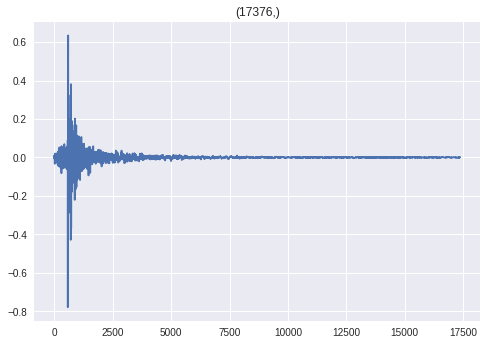

In [164]:
plt.title(y.shape)
plt.plot(y)
plt.show()

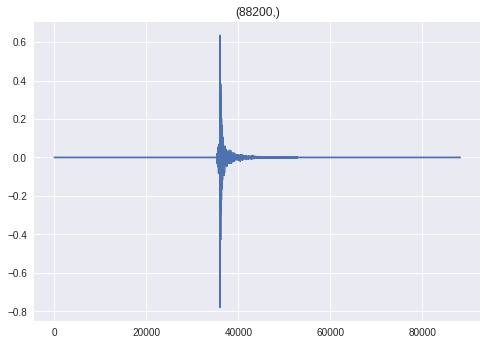

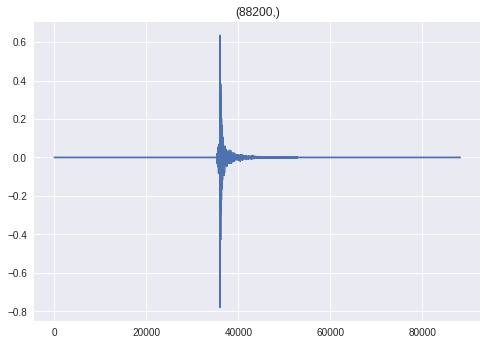

Check Equality
True


In [166]:
# hp.samples == 88200
y.shape    # == 17376

# requires to set the audio length to be 88200
offset = hp.samples - y.shape[0]
offset
padding_length = offset // 2

pad_test_1 = np.pad(y, (padding_length,), 'constant')
pad_test_2 = np.pad(y, (padding_length, hp.samples - len(y) - padding_length))

plt.title(pad_test_1.shape)
plt.plot(pad_test_1)
plt.show()

plt.title(pad_test_2.shape)
plt.plot(pad_test_2)
plt.show()

print('Check Equality')
print(np.array_equal(pad_test_1, pad_test_2))

In [141]:
print(y.shape,'\n')
IPython.display.Audio(y, rate=sr)

(17376,) 



## Comaparing difference sounds & difference audio length

In [178]:
train_df.sample(5)

,fname,labels,true_label,audio_time,audio_shape
61,03d241c1.wav,"Church_bell,Traffic_noise_and_roadway_noise",Church_bell,21.720000,957852
2734,8d9ad0b4.wav,Hi-hat,Hi-hat,0.416667,18375
1739,5ab2d233.wav,Knock,Knock,2.521973,111219
290,0f5c8134.wav,Traffic_noise_and_roadway_noise,Traffic_noise_and_roadway_noise,5.653469,249318
3952,cb4fe2eb.wav,"Sink_(filling_or_washing),Water_tap_and_faucet",Sink_(filling_or_washing),12.669546,558727


dc5cca77.wav
W/O Padding
(23023,)
Minimum Sound Length
88200
The length of the sound is 23023, its shape is (23023,)
The Converted length is 88200, its shape is (88200,)



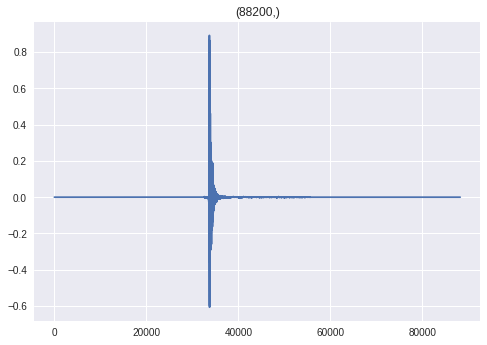

03d241c1.wav
W/O Padding
(957852,)
Minimum Sound Length
88200
The length of the sound is 957852, its shape is (957852,)
The Converted length is 88200, its shape is (88200,)



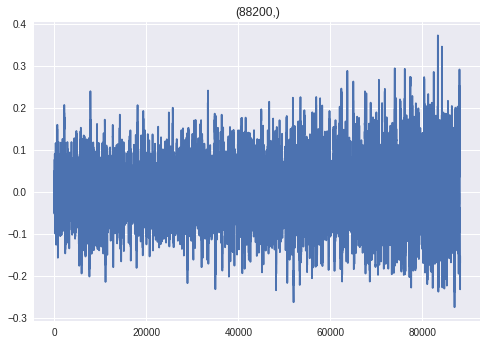

In [191]:
test_1 = hp.path + '/train_curated/' + 'dc5cca77.wav'   # < 80000
test_2 = hp.path + '/train_curated/' + '03d241c1.wav'   # > 80000

file_list = [test_1, test_2]

for file in file_list:
  y, sr = librosa.load(file, sr=44100)
  print(file.split('/')[-1])
  print('W/O Padding')
  print(y.shape)

  print('Minimum Sound Length')
  print(hp.samples)

  print('The length of the sound is {}, its shape is {}'.format(len(y), y.shape))
  if len(y) > hp.samples:
    y = y[0:0+hp.samples]
    print('The Converted length is {}, its shape is {}'.format(len(y), y.shape))
    print()

  else:
    offset = hp.samples - y.shape[0]
    offset
    padding_length = offset // 2
    y = np.pad(y, (padding_length, hp.samples - len(y) - padding_length), 'constant')  # this is necessary, because if the audio length is even, it requires to pad 1 more.
    print('The Converted length is {}, its shape is {}'.format(len(y), y.shape))
    print()

  plt.title(y.shape)
  plt.plot(y)
  plt.show()

In [184]:
# sound chekcer 
print('short')
display(IPython.display.Audio(test_1))  # 1 sec sound
 
print('long')
display(IPython.display.Audio(test_2))  # 22 sec sound # <- original label == church_bell, but included surrounded sounds

Output hidden; open in https://colab.research.google.com to view.

### Cont'

In [45]:
hp.sampling_rate

44100

In [37]:
y_idx

array([  3072, 259072])

In [41]:
(y_idx[1] - y_idx[0]) // 2

128000 - min_samples

105950

In [42]:
max(0, 128000 - min_samples // 2)

116975